Tamanho do conjunto de treino após seleção de classes: (15000, 32, 32, 3)
Tamanho do conjunto de treino antes da remoção de outliers: (15000, 3072)
Tamanho do conjunto de treino após remoção de outliers: (13500, 3072)
Tamanho do conjunto de treino após PCA: (13500, 50)
Tamanho do conjunto de treino após LDA: (13500, 2)
Tamanho do conjunto de teste após PCA: (3000, 50)
Tamanho do conjunto de teste após LDA: (3000, 2)
Relatório de Classificação (KNN):
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1000
           1       0.71      0.68      0.70      1000
           2       0.69      0.62      0.65      1000

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000



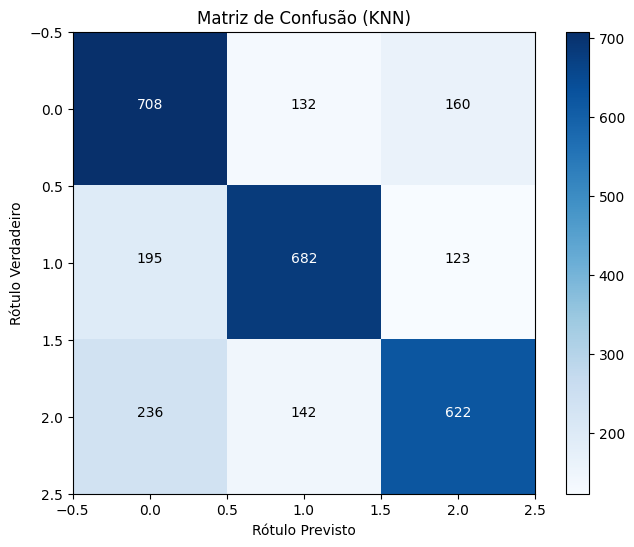

Relatório de Classificação (SVM):
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      1000
           1       0.78      0.70      0.74      1000
           2       0.68      0.74      0.71      1000

    accuracy                           0.71      3000
   macro avg       0.72      0.71      0.71      3000
weighted avg       0.72      0.71      0.71      3000



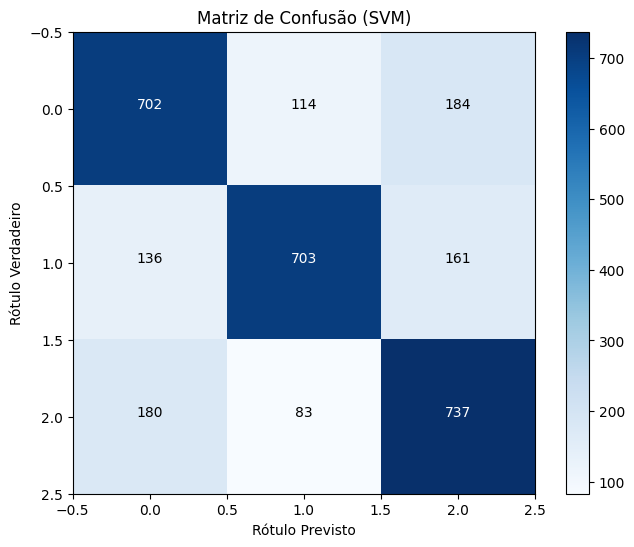

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      1000
           1       0.72      0.69      0.71      1000
           2       0.66      0.67      0.67      1000

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



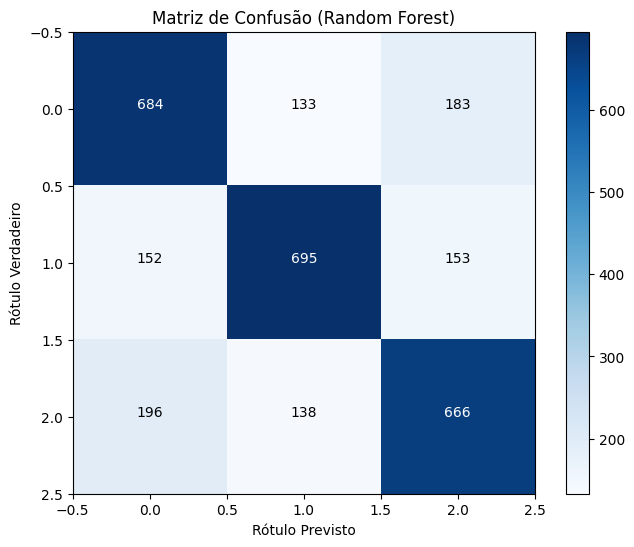

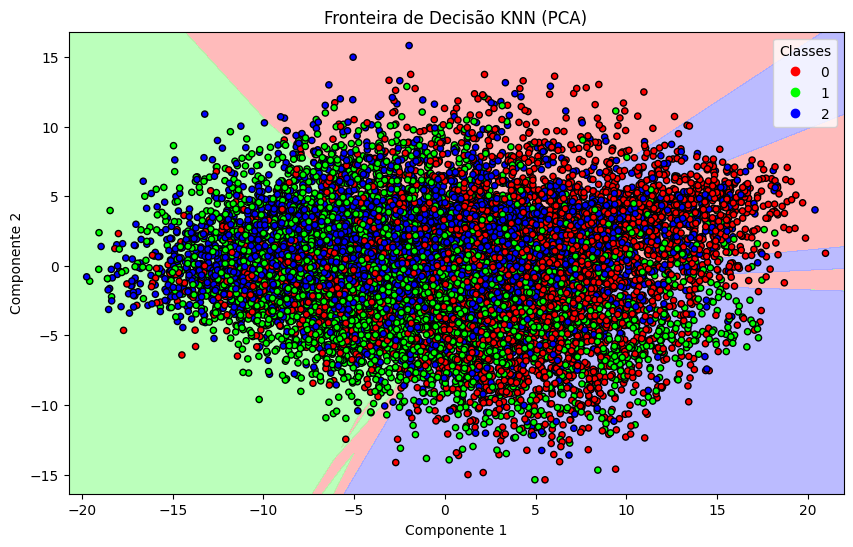

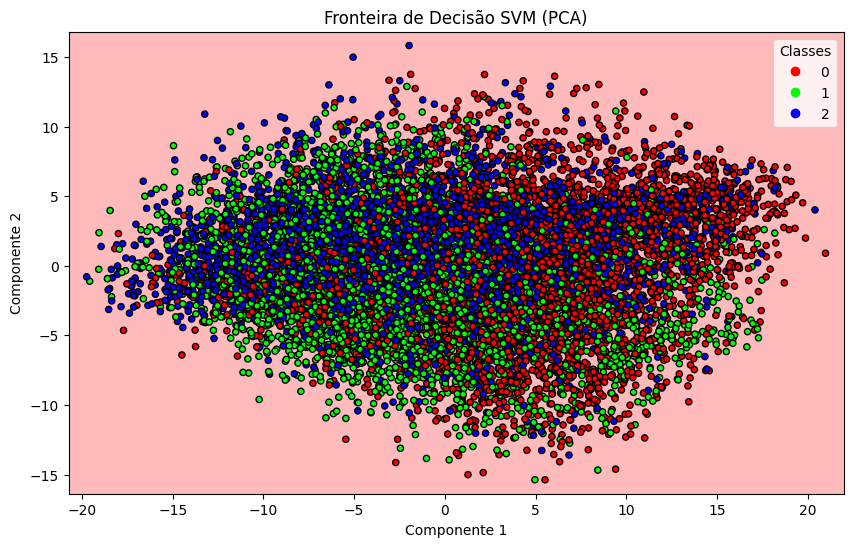

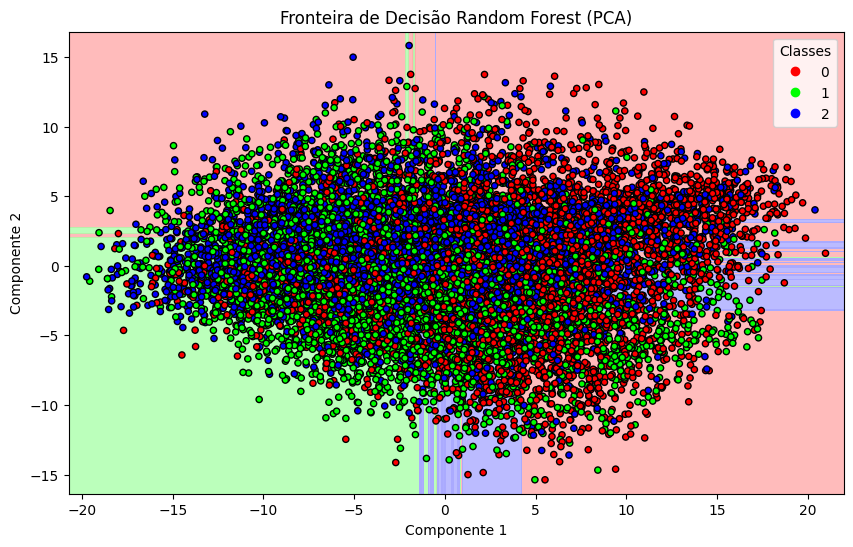

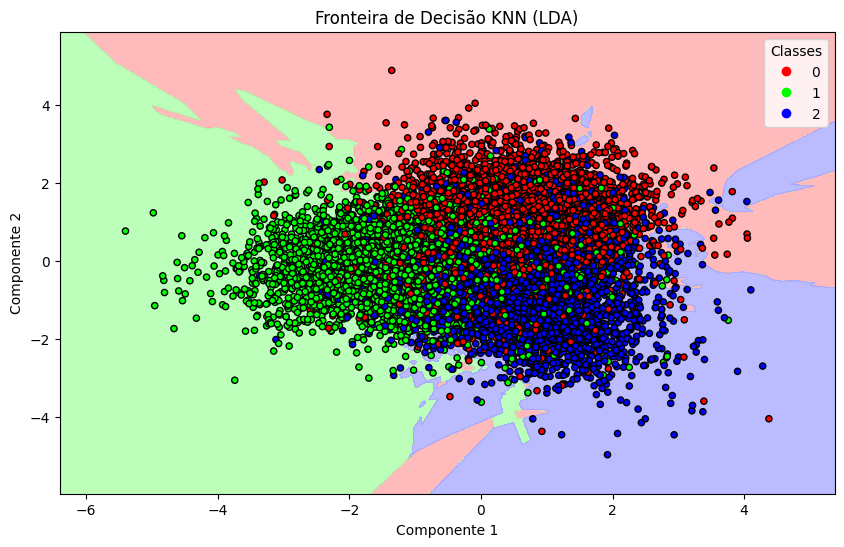

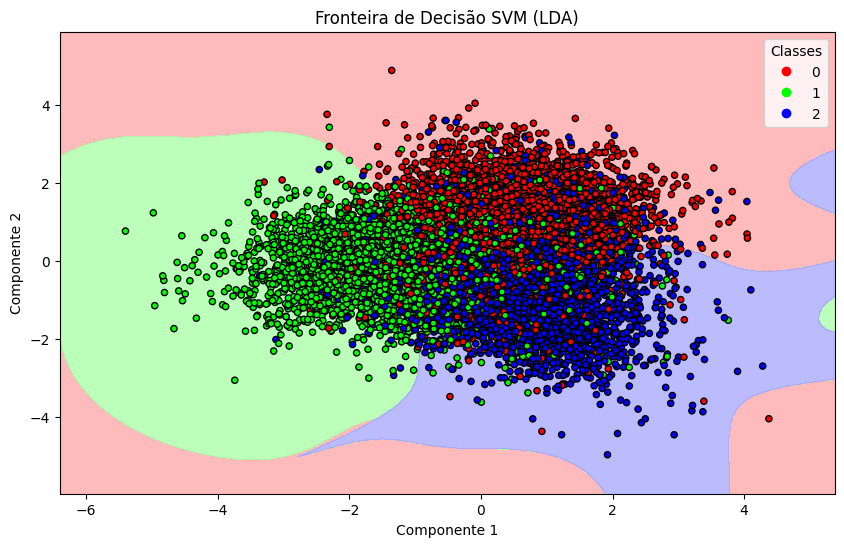

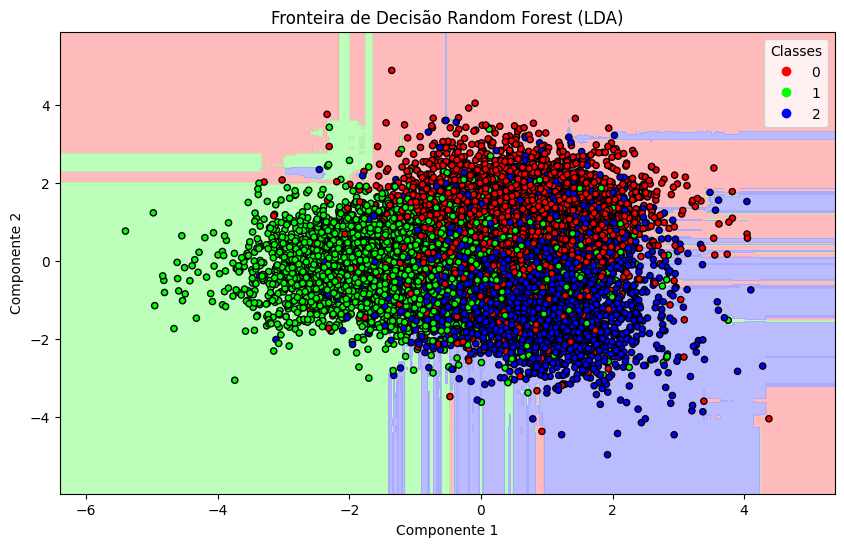

['modelo_rf.pkl']

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from matplotlib.colors import ListedColormap
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV

# Função para carregar e normalizar o conjunto de dados CIFAR-10, filtrando para 3 classes
def carregar_e_normalizar_dados(classes_selecionadas):
    (X_treino, y_treino), (X_teste, y_teste) = cifar10.load_data()
    X_treino, X_teste = X_treino / 255.0, X_teste / 255.0  # Normalização

    # Filtrar para manter apenas as classes selecionadas
    indices_treino = np.isin(y_treino, classes_selecionadas).flatten()
    indices_teste = np.isin(y_teste, classes_selecionadas).flatten()

    X_treino, y_treino = X_treino[indices_treino], y_treino[indices_treino]
    X_teste, y_teste = X_teste[indices_teste], y_teste[indices_teste]

    print(f"Tamanho do conjunto de treino após seleção de classes: {X_treino.shape}")

    return X_treino, y_treino, X_teste, y_teste

# Função para aplicar PCA e remover outliers
def aplicar_pca_e_remover_outliers(X_treino, y_treino, n_componentes, contam=0.1):
    X_treino_reshaped = X_treino.reshape(len(X_treino), -1)
    print(f"Tamanho do conjunto de treino antes da remoção de outliers: {X_treino_reshaped.shape}")

    # Remover outliers usando Isolation Forest
    isol_forest = IsolationForest(contamination=contam, random_state=42)
    inliers_mask = isol_forest.fit_predict(X_treino_reshaped) == 1

    # Manter apenas os inliers
    X_treino_filtered = X_treino_reshaped[inliers_mask]
    y_treino_filtered = y_treino[inliers_mask]
    print(f"Tamanho do conjunto de treino após remoção de outliers: {X_treino_filtered.shape}")

    # Aplicar PCA nos dados filtrados
    pca = PCA(n_components=n_componentes)
    X_treino_pca = pca.fit_transform(X_treino_filtered)
    print(f"Tamanho do conjunto de treino após PCA: {X_treino_pca.shape}")

    return X_treino_pca, y_treino_filtered, pca

# Função para aplicar LDA
def aplicar_lda(X_treino, y_treino, n_componentes):
    lda = LDA(n_components=n_componentes)
    X_treino_lda = lda.fit_transform(X_treino, y_treino.ravel())
    print(f"Tamanho do conjunto de treino após LDA: {X_treino_lda.shape}")
    return X_treino_lda, lda

# Função para plotar a fronteira de decisão
def plotar_fronteira_decisao(X, y, modelo, titulo='Fronteira de Decisão'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.title(titulo)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

# Carregar e normalizar dados para as classes 0, 1 e 2
classes_selecionadas = [0, 1, 2]
X_treino, y_treino, X_teste, y_teste = carregar_e_normalizar_dados(classes_selecionadas)

# Aplicar PCA e remover outliers no conjunto de treino
X_treino_pca, y_treino_pca, pca_treino = aplicar_pca_e_remover_outliers(X_treino, y_treino, n_componentes=50)

# Aplicar LDA no conjunto de treino
X_treino_lda, lda_treino = aplicar_lda(X_treino_pca, y_treino_pca, n_componentes=2)

# Aplicar PCA no conjunto de teste
X_teste_reshaped = X_teste.reshape(len(X_teste), -1)
X_teste_pca = pca_treino.transform(X_teste_reshaped)
print(f"Tamanho do conjunto de teste após PCA: {X_teste_pca.shape}")

# Aplicar LDA no conjunto de teste
X_teste_lda = lda_treino.transform(X_teste_pca)
print(f"Tamanho do conjunto de teste após LDA: {X_teste_lda.shape}")

# Treinar e avaliar KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_treino_lda, y_treino_pca.ravel())
y_pred_knn = knn.predict(X_teste_lda)
print("Relatório de Classificação (KNN):")
print(classification_report(y_teste, y_pred_knn))
plotar_matriz_confusao(y_teste, y_pred_knn, titulo='Matriz de Confusão (KNN)')

# Treinar e avaliar SVM
svm = SVC(kernel='rbf', C=10)
svm.fit(X_treino_lda, y_treino_pca.ravel())
y_pred_svm = svm.predict(X_teste_lda)
print("Relatório de Classificação (SVM):")
print(classification_report(y_teste, y_pred_svm))
plotar_matriz_confusao(y_teste, y_pred_svm, titulo='Matriz de Confusão (SVM)')

# Treinar e avaliar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_treino_lda, y_treino_pca.ravel())
y_pred_rf = rf.predict(X_teste_lda)
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_teste, y_pred_rf))
plotar_matriz_confusao(y_teste, y_pred_rf, titulo='Matriz de Confusão (Random Forest)')

# Plotar fronteiras de decisão para KNN, SVM, e Random Forest antes e depois de aplicar LDA
# Para PCA
plotar_fronteira_decisao(X_treino_pca[:, :2], y_treino_pca, knn, titulo='Fronteira de Decisão KNN (PCA)')
plotar_fronteira_decisao(X_treino_pca[:, :2], y_treino_pca, svm, titulo='Fronteira de Decisão SVM (PCA)')
plotar_fronteira_decisao(X_treino_pca[:, :2], y_treino_pca, rf, titulo='Fronteira de Decisão Random Forest (PCA)')

# Para LDA
plotar_fronteira_decisao(X_treino_lda, y_treino_pca, knn, titulo='Fronteira de Decisão KNN (LDA)')
plotar_fronteira_decisao(X_treino_lda, y_treino_pca, svm, titulo='Fronteira de Decisão SVM (LDA)')
plotar_fronteira_decisao(X_treino_lda, y_treino_pca, rf, titulo='Fronteira de Decisão Random Forest (LDA)')

# Salvar os modelos
joblib.dump(knn, "modelo_knn.pkl")
joblib.dump(svm, "modelo_svm.pkl")
joblib.dump(rf, "modelo_rf.pkl")

In [18]:
import pandas as pd
from sklearn.metrics import classification_report

# Carregar os modelos salvos
knn = joblib.load("modelo_knn.pkl")
svm = joblib.load("modelo_svm.pkl")
rf = joblib.load("modelo_rf.pkl")

# Função para obter o relatório de classificação e convertê-lo em DataFrame
def obter_relatorio_df(y_verdadeiro, y_pred, modelo_nome):
    relatorio = classification_report(y_verdadeiro, y_pred, output_dict=True)
    df = pd.DataFrame(relatorio).transpose()
    df['Modelo'] = modelo_nome
    return df

# Prever e obter relatórios de classificação para cada modelo usando dados de teste LDA
y_pred_knn_lda = knn.predict(X_teste_lda)
y_pred_svm_lda = svm.predict(X_teste_lda)
y_pred_rf_lda = rf.predict(X_teste_lda)

# Criar DataFrames
df_knn_lda = obter_relatorio_df(y_teste, y_pred_knn_lda, 'KNN (LDA)')
df_svm_lda = obter_relatorio_df(y_teste, y_pred_svm_lda, 'SVM (LDA)')
df_rf_lda = obter_relatorio_df(y_teste, y_pred_rf_lda, 'Random Forest (LDA)')

# Concatenar os DataFrames para exibição
df_resultados_lda = pd.concat([df_knn_lda, df_svm_lda, df_rf_lda], keys=['KNN', 'SVM', 'Random Forest'])

# Prever e obter relatórios de classificação para cada modelo usando dados de teste PCA
y_pred_knn_pca = knn.predict(X_teste_pca[:, :2])
y_pred_svm_pca = svm.predict(X_teste_pca[:, :2])
y_pred_rf_pca = rf.predict(X_teste_pca[:, :2])

# Criar DataFrames
df_knn_pca = obter_relatorio_df(y_teste, y_pred_knn_pca, 'KNN (PCA)')
df_svm_pca = obter_relatorio_df(y_teste, y_pred_svm_pca, 'SVM (PCA)')
df_rf_pca = obter_relatorio_df(y_teste, y_pred_rf_pca, 'Random Forest (PCA)')

# Concatenar os DataFrames para exibição
df_resultados_pca = pd.concat([df_knn_pca, df_svm_pca, df_rf_pca], keys=['KNN', 'SVM', 'Random Forest'])

# Exibir os resultados
print("Resultados LDA:")
display(df_resultados_lda)

print("\nResultados PCA:")
display(df_resultados_pca)

Resultados LDA:


precision    recall  f1-score      support  \
KNN           0              0.621598  0.708000  0.661992  1000.000000   
              1              0.713389  0.682000  0.697342  1000.000000   
              2              0.687293  0.622000  0.653018  1000.000000   
              accuracy       0.670667  0.670667  0.670667     0.670667   
              macro avg      0.674093  0.670667  0.670784  3000.000000   
              weighted avg   0.674093  0.670667  0.670784  3000.000000   
SVM           0              0.689587  0.702000  0.695738  1000.000000   
              1              0.781111  0.703000  0.740000  1000.000000   
              2              0.681146  0.737000  0.707973  1000.000000   
              accuracy       0.714000  0.714000  0.714000     0.714000   
              macro avg      0.717282  0.714000  0.714570  3000.000000   
              weighted avg   0.717282  0.714000  0.714570  3000.000000   
Random Forest 0              0.662791  0.684000  0.673228  1000.000000   
              1              0.719462  0.695000  0.707019  1000.000000   
              2              0.664671  0.666000  0.665335  1000.000000   
              accuracy       0.681667  0.681667  0.681667     0.681667   
              macro avg      0.682308  0.681667  0.681861  3000.000000   
              weighted avg   0.682308  0.681667  0.681861  3000.000000   

                                         Modelo  
KNN           0                       KNN (LDA)  
              1                       KNN (LDA)  
              2                       KNN (LDA)  
              accuracy                KNN (LDA)  
              macro avg               KNN (LDA)  
              weighted avg            KNN (LDA)  
SVM           0                       SVM (LDA)  
              1                       SVM (LDA)  
              2                       SVM (LDA)  
              accuracy                SVM (LDA)  
              macro avg               SVM (LDA)  
              weighted avg            SVM (LDA)  
Random Forest 0             Random Forest (LDA)  
              1             Random Forest (LDA)  
              2             Random Forest (LDA)  
              accuracy      Random Forest (LDA)  
              macro avg     Random Forest (LDA)  
              weighted avg  Random Forest (LDA)


Resultados PCA:


precision    recall  f1-score      support  \
KNN           0              0.452199  0.473000  0.462366  1000.000000   
              1              0.434963  0.525000  0.475759  1000.000000   
              2              0.204819  0.153000  0.175157  1000.000000   
              accuracy       0.383667  0.383667  0.383667     0.383667   
              macro avg      0.363994  0.383667  0.371094  3000.000000   
              weighted avg   0.363994  0.383667  0.371094  3000.000000   
SVM           0              0.359011  0.755000  0.486626  1000.000000   
              1              0.386121  0.217000  0.277849  1000.000000   
              2              0.265672  0.089000  0.133333  1000.000000   
              accuracy       0.353667  0.353667  0.353667     0.353667   
              macro avg      0.336935  0.353667  0.299269  3000.000000   
              weighted avg   0.336935  0.353667  0.299269  3000.000000   
Random Forest 0              0.417483  0.597000  0.491358  1000.000000   
              1              0.446933  0.459000  0.452886  1000.000000   
              2              0.232044  0.126000  0.163318  1000.000000   
              accuracy       0.394000  0.394000  0.394000     0.394000   
              macro avg      0.365487  0.394000  0.369187  3000.000000   
              weighted avg   0.365487  0.394000  0.369187  3000.000000   

                                         Modelo  
KNN           0                       KNN (PCA)  
              1                       KNN (PCA)  
              2                       KNN (PCA)  
              accuracy                KNN (PCA)  
              macro avg               KNN (PCA)  
              weighted avg            KNN (PCA)  
SVM           0                       SVM (PCA)  
              1                       SVM (PCA)  
              2                       SVM (PCA)  
              accuracy                SVM (PCA)  
              macro avg               SVM (PCA)  
              weighted avg            SVM (PCA)  
Random Forest 0             Random Forest (PCA)  
              1             Random Forest (PCA)  
              2             Random Forest (PCA)  
              accuracy      Random Forest (PCA)  
              macro avg     Random Forest (PCA)  
              weighted avg  Random Forest (PCA)

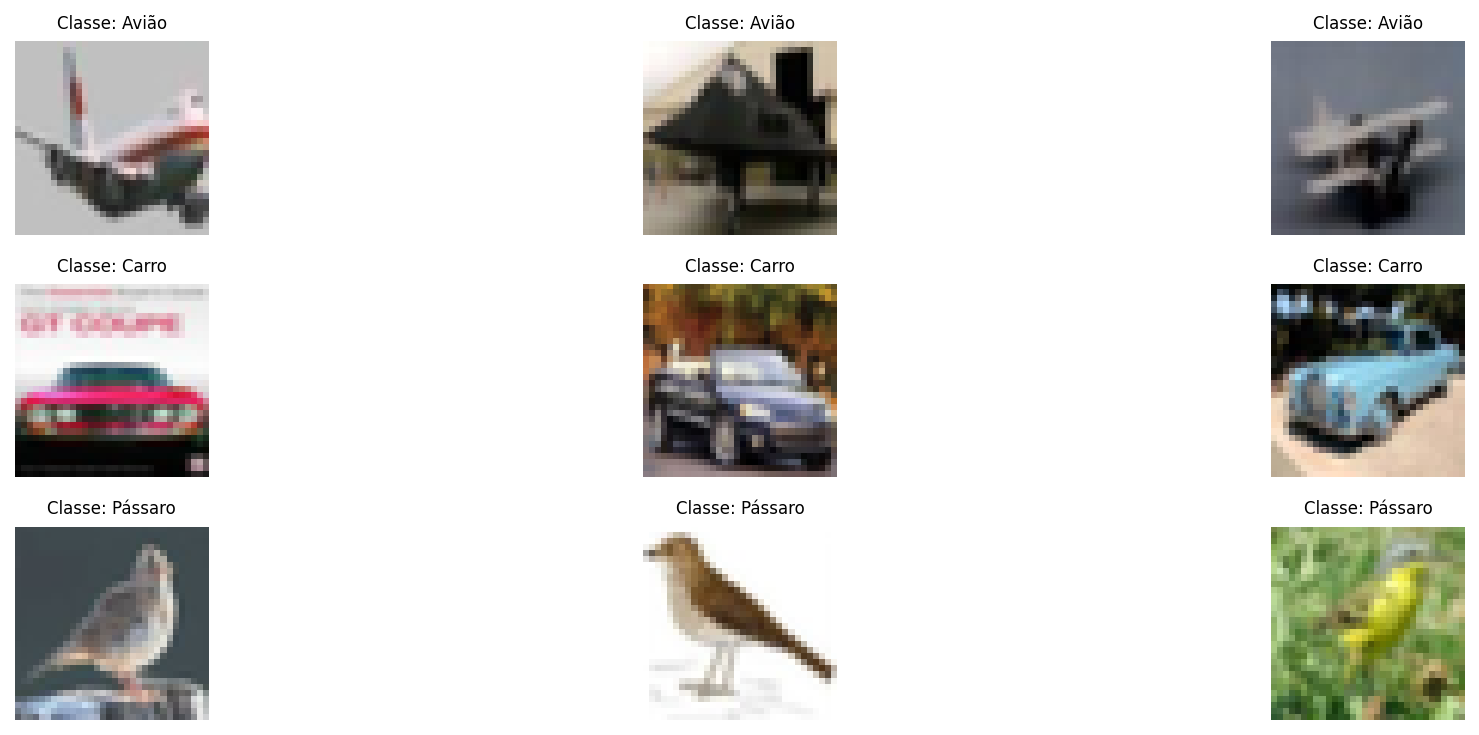

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Função para exibir 3 amostras de cada classe do conjunto de treinamento com melhor qualidade
def exibir_amostras_por_classe(X_treino, y_treino, classes, num_amostras=3):
    """
    Exibe um número fixo de imagens para cada classe no conjunto de treinamento, com qualidade melhorada.

    Args:
        X_treino (numpy.ndarray): Conjunto de imagens de treinamento.
        y_treino (numpy.ndarray): Rótulos correspondentes ao conjunto de treinamento.
        classes (list): Lista com os nomes das classes.
        num_amostras (int): Número de amostras a serem exibidas por classe.
    """
    plt.figure(figsize=(15, 5), dpi=150)  # Ajustar o tamanho e a resolução

    for classe_idx, classe_nome in enumerate(classes):
        # Filtrar imagens pertencentes à classe atual
        indices_classe = np.where(y_treino.flatten() == classe_idx)[0]
        # Selecionar aleatoriamente as amostras da classe
        indices_amostras = np.random.choice(indices_classe, num_amostras, replace=False)
        
        for i, idx in enumerate(indices_amostras):
            plt.subplot(len(classes), num_amostras, classe_idx * num_amostras + i + 1)
            plt.imshow(X_treino[idx])  # Exibir a imagem
            plt.title(f"Classe: {classe_nome}", fontsize=8)  # Exibir o nome da classe
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Lista de classes
classes = ["Avião", "Carro", "Pássaro"]  # Nomes das classes (0, 1, 2)

# Exibir 3 amostras de cada classe do conjunto de treinamento
exibir_amostras_por_classe(X_treino, y_treino, classes)

### Agora com a mmetade do conjunto de treinamento e teste.

Tamanho do conjunto de treino após redução: (300, 32, 32, 3)
Tamanho do conjunto de teste após redução: (300, 32, 32, 3)
Tamanho do conjunto de treino antes da remoção de outliers: (300, 3072)
Tamanho do conjunto de treino após remoção de outliers: (270, 3072)
Tamanho do conjunto de treino após PCA: (270, 50)
Tamanho do conjunto de treino após LDA: (270, 2)
Tamanho do conjunto de teste após PCA: (300, 50)
Tamanho do conjunto de teste após LDA: (300, 2)
Relatório de Classificação (KNN):
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       100
           1       0.67      0.63      0.65       100
           2       0.60      0.64      0.62       100

    accuracy                           0.63       300
   macro avg       0.63      0.63      0.63       300
weighted avg       0.63      0.63      0.63       300

Relatório de Classificação (SVM):
              precision    recall  f1-score   support

           0       0.63      0.59      

,precision,recall,f1-score,support,Modelo
0,0.630000,0.630000,0.630000,100.000000,KNN (LDA)
1,0.670213,0.630000,0.649485,100.000000,KNN (LDA)
2,0.603774,0.640000,0.621359,100.000000,KNN (LDA)
accuracy,0.633333,0.633333,0.633333,0.633333,KNN (LDA)
macro avg,0.634662,0.633333,0.633615,300.000000,KNN (LDA)
weighted avg,0.634662,0.633333,0.633615,300.000000,KNN (LDA)
0,0.627660,0.590000,0.608247,100.000000,SVM (LDA)
1,0.677419,0.630000,0.652850,100.000000,SVM (LDA)
2,0.601770,0.680000,0.638498,100.000000,SVM (LDA)
accuracy,0.633333,0.633333,0.633333,0.633333,SVM (LDA)



Resultados PCA:


,precision,recall,f1-score,support,Modelo
0,0.404255,0.190000,0.258503,100.000000,KNN (PCA)
1,0.455882,0.620000,0.525424,100.000000,KNN (PCA)
2,0.247863,0.290000,0.267281,100.000000,KNN (PCA)
accuracy,0.366667,0.366667,0.366667,0.366667,KNN (PCA)
macro avg,0.369334,0.366667,0.350403,300.000000,KNN (PCA)
weighted avg,0.369334,0.366667,0.350403,300.000000,KNN (PCA)
0,0.369159,0.790000,0.503185,100.000000,SVM (PCA)
1,0.360656,0.220000,0.273292,100.000000,SVM (PCA)
2,0.280000,0.070000,0.112000,100.000000,SVM (PCA)
accuracy,0.360000,0.360000,0.360000,0.360000,SVM (PCA)


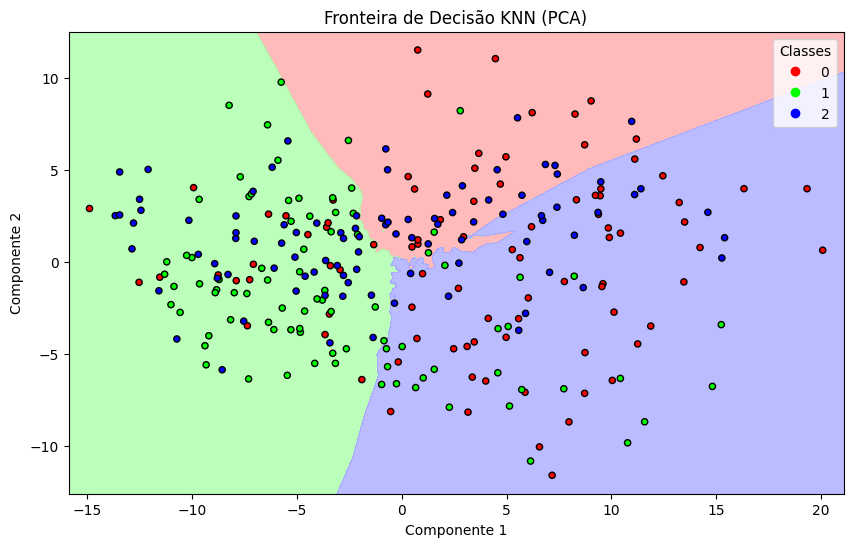

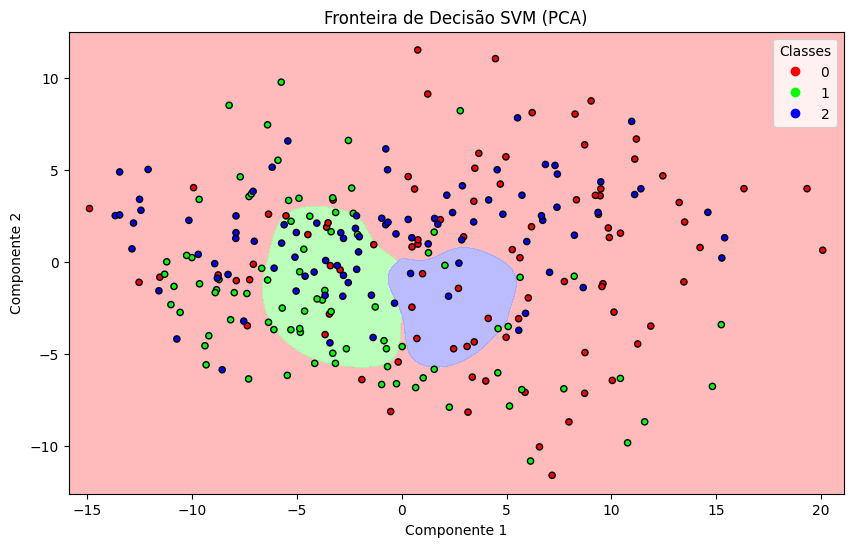

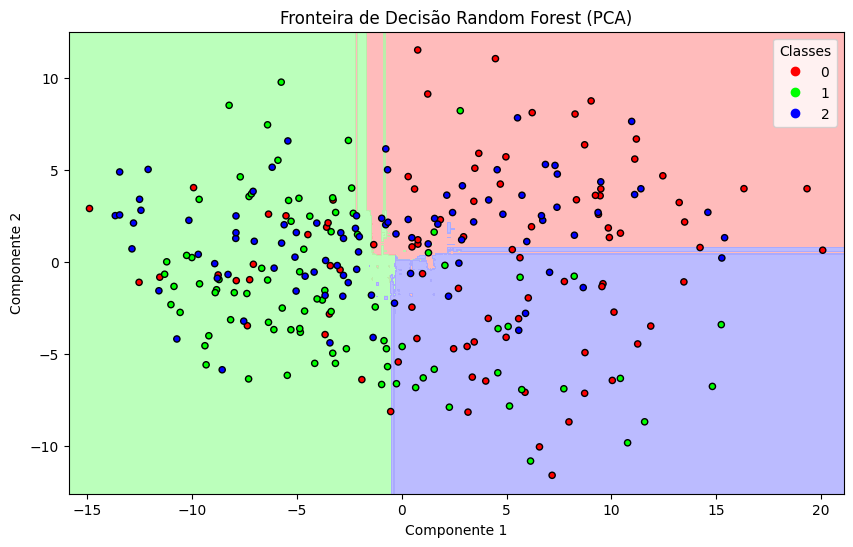

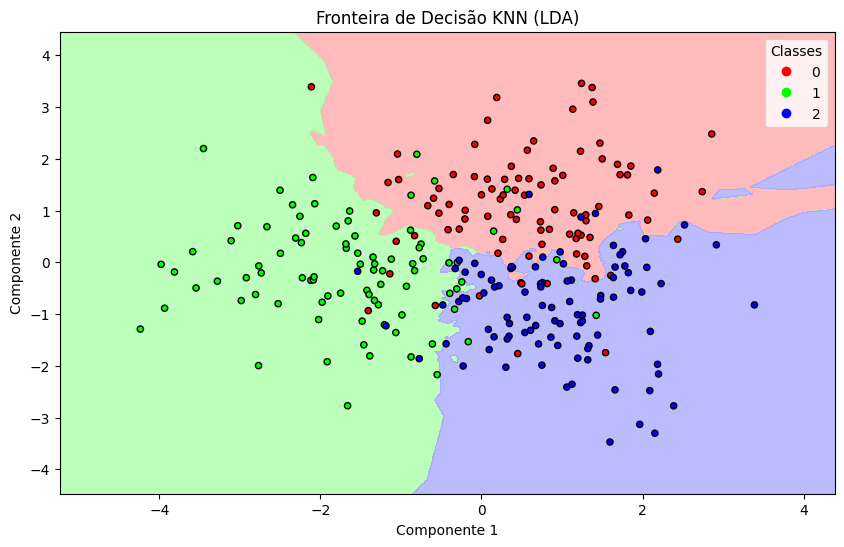

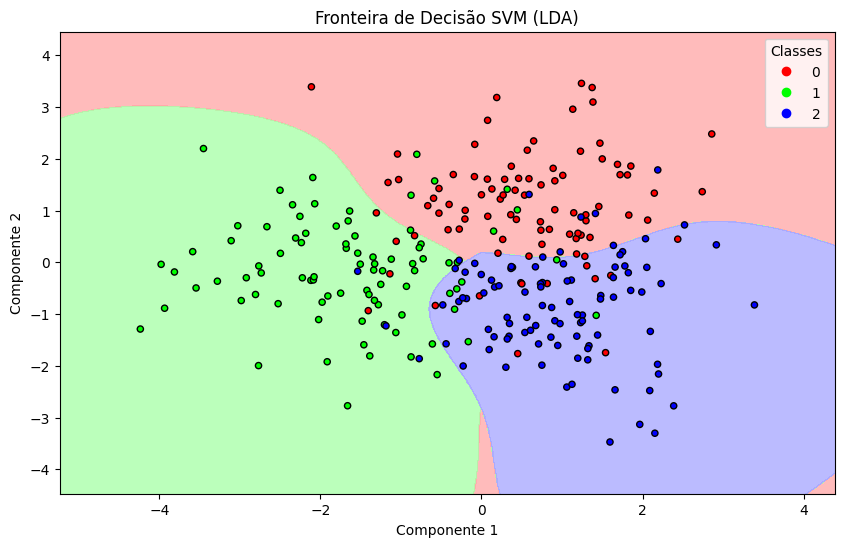

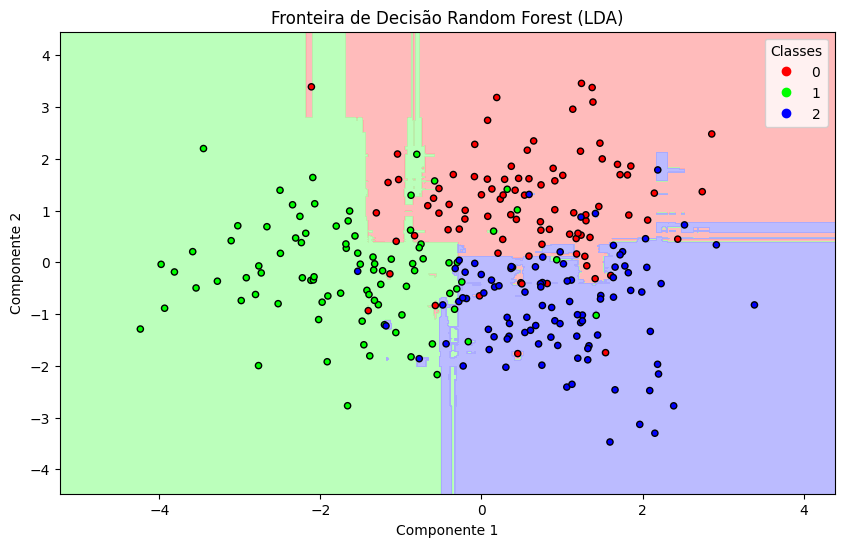

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from matplotlib.colors import ListedColormap
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd

# Função para carregar e normalizar o conjunto de dados CIFAR-10, reduzindo para 100 amostras por classe
def carregar_e_normalizar_dados(classes_selecionadas, num_amostras_por_classe=100):
    (X_treino, y_treino), (X_teste, y_teste) = cifar10.load_data()
    X_treino, X_teste = X_treino / 255.0, X_teste / 255.0  # Normalização

    # Filtrar para manter apenas as classes selecionadas
    indices_treino = np.isin(y_treino, classes_selecionadas).flatten()
    indices_teste = np.isin(y_teste, classes_selecionadas).flatten()

    X_treino, y_treino = X_treino[indices_treino], y_treino[indices_treino]
    X_teste, y_teste = X_teste[indices_teste], y_teste[indices_teste]

    # Selecionar apenas num_amostras_por_classe de cada classe
    X_treino_reduzido, y_treino_reduzido = [], []
    X_teste_reduzido, y_teste_reduzido = [], []

    for classe in classes_selecionadas:
        # Treinamento
        indices_classe_treino = np.where(y_treino == classe)[0][:num_amostras_por_classe]
        X_treino_reduzido.append(X_treino[indices_classe_treino])
        y_treino_reduzido.append(y_treino[indices_classe_treino])

        # Teste
        indices_classe_teste = np.where(y_teste == classe)[0][:num_amostras_por_classe]
        X_teste_reduzido.append(X_teste[indices_classe_teste])
        y_teste_reduzido.append(y_teste[indices_classe_teste])

    X_treino = np.concatenate(X_treino_reduzido)
    y_treino = np.concatenate(y_treino_reduzido)
    X_teste = np.concatenate(X_teste_reduzido)
    y_teste = np.concatenate(y_teste_reduzido)

    print(f"Tamanho do conjunto de treino após redução: {X_treino.shape}")
    print(f"Tamanho do conjunto de teste após redução: {X_teste.shape}")

    return X_treino, y_treino, X_teste, y_teste

# Função para aplicar PCA e remover outliers
def aplicar_pca_e_remover_outliers(X_treino, y_treino, n_componentes, contam=0.1):
    X_treino_reshaped = X_treino.reshape(len(X_treino), -1)
    print(f"Tamanho do conjunto de treino antes da remoção de outliers: {X_treino_reshaped.shape}")

    # Remover outliers usando Isolation Forest
    isol_forest = IsolationForest(contamination=contam, random_state=42)
    inliers_mask = isol_forest.fit_predict(X_treino_reshaped) == 1

    # Manter apenas os inliers
    X_treino_filtered = X_treino_reshaped[inliers_mask]
    y_treino_filtered = y_treino[inliers_mask]
    print(f"Tamanho do conjunto de treino após remoção de outliers: {X_treino_filtered.shape}")

    # Aplicar PCA nos dados filtrados
    pca = PCA(n_components=n_componentes)
    X_treino_pca = pca.fit_transform(X_treino_filtered)
    print(f"Tamanho do conjunto de treino após PCA: {X_treino_pca.shape}")

    return X_treino_pca, y_treino_filtered, pca

# Função para aplicar LDA
def aplicar_lda(X_treino, y_treino, n_componentes):
    lda = LDA(n_components=n_componentes)
    X_treino_lda = lda.fit_transform(X_treino, y_treino.ravel())
    print(f"Tamanho do conjunto de treino após LDA: {X_treino_lda.shape}")
    return X_treino_lda, lda

# Função para plotar a fronteira de decisão
def plotar_fronteira_decisao(X, y, modelo, titulo='Fronteira de Decisão'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.title(titulo)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

# Lista de classes selecionadas
classes_selecionadas = [0, 1, 2]

# Carregar e normalizar os dados reduzidos
X_treino, y_treino, X_teste, y_teste = carregar_e_normalizar_dados(classes_selecionadas)

# Aplicar PCA e remover outliers no conjunto de treino
X_treino_pca, y_treino_pca, pca_treino = aplicar_pca_e_remover_outliers(X_treino, y_treino, n_componentes=50)

# Aplicar LDA no conjunto de treino
X_treino_lda, lda_treino = aplicar_lda(X_treino_pca, y_treino_pca, n_componentes=2)

# Aplicar PCA no conjunto de teste
X_teste_reshaped = X_teste.reshape(len(X_teste), -1)
X_teste_pca = pca_treino.transform(X_teste_reshaped)
print(f"Tamanho do conjunto de teste após PCA: {X_teste_pca.shape}")

# Aplicar LDA no conjunto de teste
X_teste_lda = lda_treino.transform(X_teste_pca)
print(f"Tamanho do conjunto de teste após LDA: {X_teste_lda.shape}")

# Treinar e avaliar KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_treino_lda, y_treino_pca.ravel())
y_pred_knn = knn.predict(X_teste_lda)
print("Relatório de Classificação (KNN):")
print(classification_report(y_teste, y_pred_knn))

# Treinar e avaliar SVM
svm = SVC(kernel='rbf', C=10)
svm.fit(X_treino_lda, y_treino_pca.ravel())
y_pred_svm = svm.predict(X_teste_lda)
print("Relatório de Classificação (SVM):")
print(classification_report(y_teste, y_pred_svm))

# Treinar e avaliar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_treino_lda, y_treino_pca.ravel())
y_pred_rf = rf.predict(X_teste_lda)
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_teste, y_pred_rf))

# Salvar os modelos com novos nomes
joblib.dump(knn, "modelo_knn_reduzido.pkl")
joblib.dump(svm, "modelo_svm_reduzido.pkl")
joblib.dump(rf, "modelo_rf_reduzido.pkl")

# Comparação de Resultados:
def obter_relatorio_df(y_verdadeiro, y_pred, modelo_nome):
    relatorio = classification_report(y_verdadeiro, y_pred, output_dict=True)
    df = pd.DataFrame(relatorio).transpose()
    df['Modelo'] = modelo_nome
    return df

# LDA Resultados
df_knn_lda = obter_relatorio_df(y_teste, y_pred_knn, 'KNN (LDA)')
df_svm_lda = obter_relatorio_df(y_teste, y_pred_svm, 'SVM (LDA)')
df_rf_lda = obter_relatorio_df(y_teste, y_pred_rf, 'Random Forest (LDA)')
df_resultados_lda = pd.concat([df_knn_lda, df_svm_lda, df_rf_lda])

# PCA Resultados
y_pred_knn_pca = knn.predict(X_teste_pca[:, :2])
y_pred_svm_pca = svm.predict(X_teste_pca[:, :2])
y_pred_rf_pca = rf.predict(X_teste_pca[:, :2])
df_knn_pca = obter_relatorio_df(y_teste, y_pred_knn_pca, 'KNN (PCA)')
df_svm_pca = obter_relatorio_df(y_teste, y_pred_svm_pca, 'SVM (PCA)')
df_rf_pca = obter_relatorio_df(y_teste, y_pred_rf_pca, 'Random Forest (PCA)')
df_resultados_pca = pd.concat([df_knn_pca, df_svm_pca, df_rf_pca])

print("Resultados LDA:")
display(df_resultados_lda)

print("\nResultados PCA:")
display(df_resultados_pca)

# Plotar fronteiras de decisão
plotar_fronteira_decisao(X_treino_pca[:, :2], y_treino_pca, knn, titulo='Fronteira de Decisão KNN (PCA)')
plotar_fronteira_decisao(X_treino_pca[:, :2], y_treino_pca, svm, titulo='Fronteira de Decisão SVM (PCA)')
plotar_fronteira_decisao(X_treino_pca[:, :2], y_treino_pca, rf, titulo='Fronteira de Decisão Random Forest (PCA)')

plotar_fronteira_decisao(X_treino_lda, y_treino_pca, knn, titulo='Fronteira de Decisão KNN (LDA)')
plotar_fronteira_decisao(X_treino_lda, y_treino_pca, svm, titulo='Fronteira de Decisão SVM (LDA)')
plotar_fronteira_decisao(X_treino_lda, y_treino_pca, rf, titulo='Fronteira de Decisão Random Forest (LDA)')

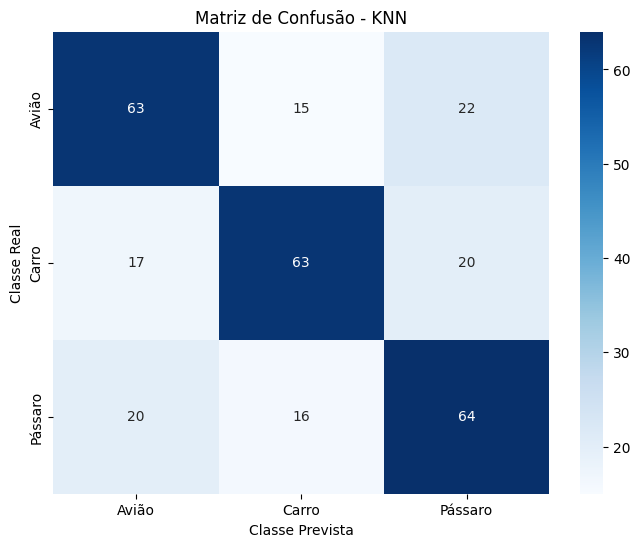

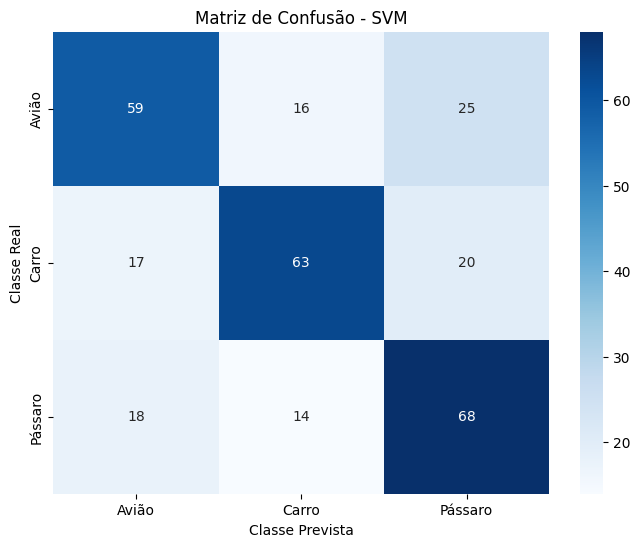

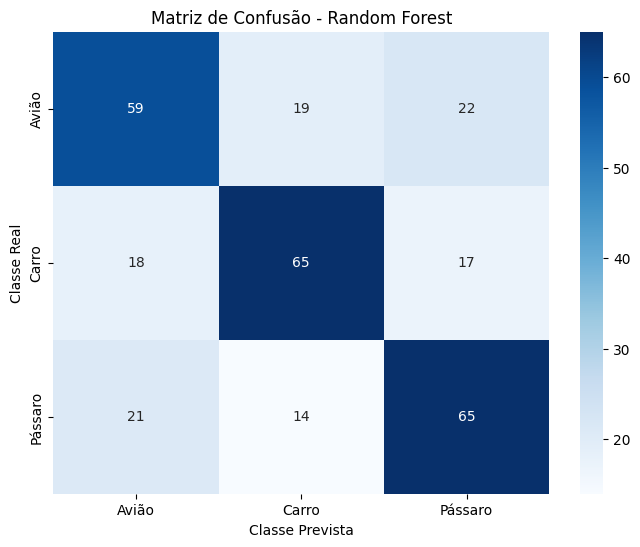

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar matriz de confusão
def plotar_matriz_confusao(y_true, y_pred, classes, modelo_nome):
    """
    Plota a matriz de confusão com valores anotados.

    Args:
        y_true (array): Rótulos reais.
        y_pred (array): Rótulos previstos pelo modelo.
        classes (list): Lista com os nomes das classes.
        modelo_nome (str): Nome do modelo para o título do gráfico.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de Confusão - {modelo_nome}')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()

# Lista de classes
classes = ["Avião", "Carro", "Pássaro"]

# Plotar matrizes de confusão para cada modelo
plotar_matriz_confusao(y_teste, y_pred_knn, classes, "KNN")
plotar_matriz_confusao(y_teste, y_pred_svm, classes, "SVM")
plotar_matriz_confusao(y_teste, y_pred_rf, classes, "Random Forest")

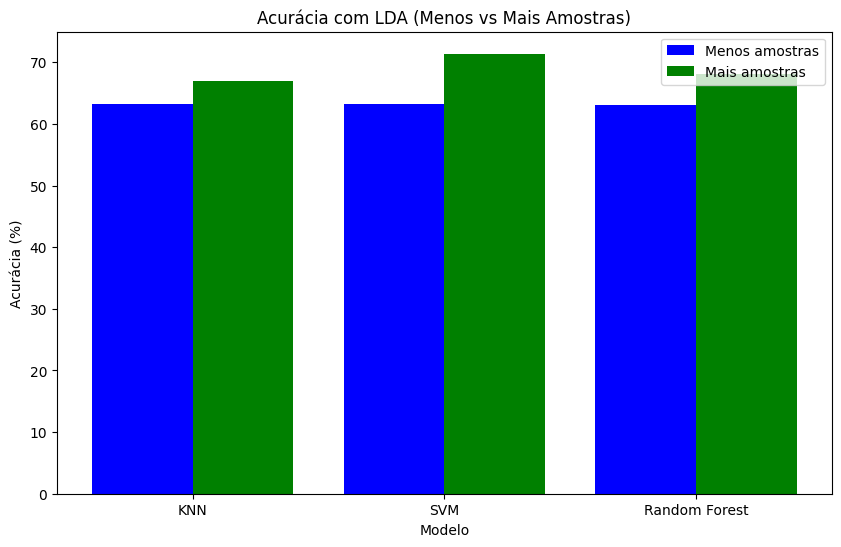

In [26]:
import matplotlib.pyplot as plt

modelos = ['KNN', 'SVM', 'Random Forest']
acuracia_menos = [63.3, 63.3, 63.0]
acuracia_mais = [67.0, 71.4, 68.1]

x = range(len(modelos))

plt.figure(figsize=(10, 6))
plt.bar(x, acuracia_menos, width=0.4, label='Menos amostras', color='blue')
plt.bar([p + 0.4 for p in x], acuracia_mais, width=0.4, label='Mais amostras', color='green')
plt.xticks([p + 0.2 for p in x], modelos)
plt.title('Acurácia com LDA (Menos vs Mais Amostras)')
plt.ylabel('Acurácia (%)')
plt.xlabel('Modelo')
plt.legend()
plt.show()

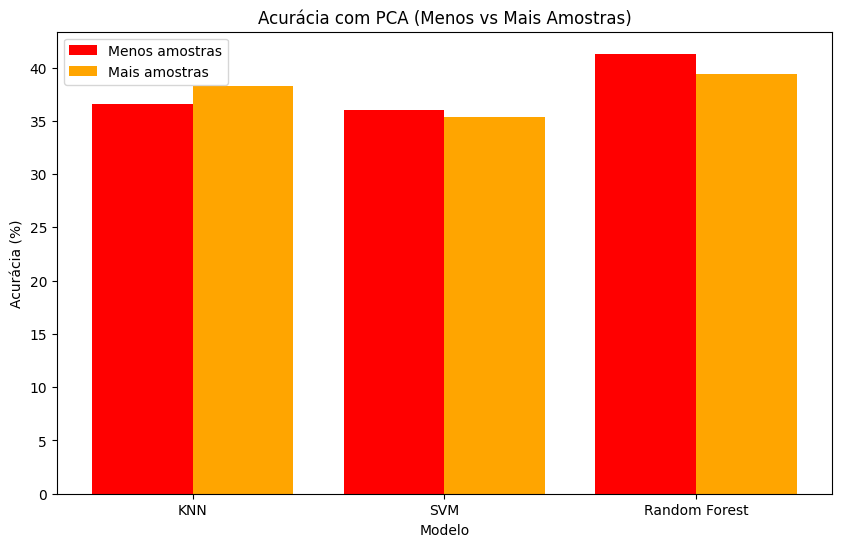

In [27]:
acuracia_pca_menos = [36.6, 36.0, 41.3]
acuracia_pca_mais = [38.3, 35.4, 39.4]

plt.figure(figsize=(10, 6))
plt.bar(x, acuracia_pca_menos, width=0.4, label='Menos amostras', color='red')
plt.bar([p + 0.4 for p in x], acuracia_pca_mais, width=0.4, label='Mais amostras', color='orange')
plt.xticks([p + 0.2 for p in x], modelos)
plt.title('Acurácia com PCA (Menos vs Mais Amostras)')
plt.ylabel('Acurácia (%)')
plt.xlabel('Modelo')
plt.legend()
plt.show()